r correlation (Pearson's r) = 0.894375
 MAPE mean = 0.08642780882318908


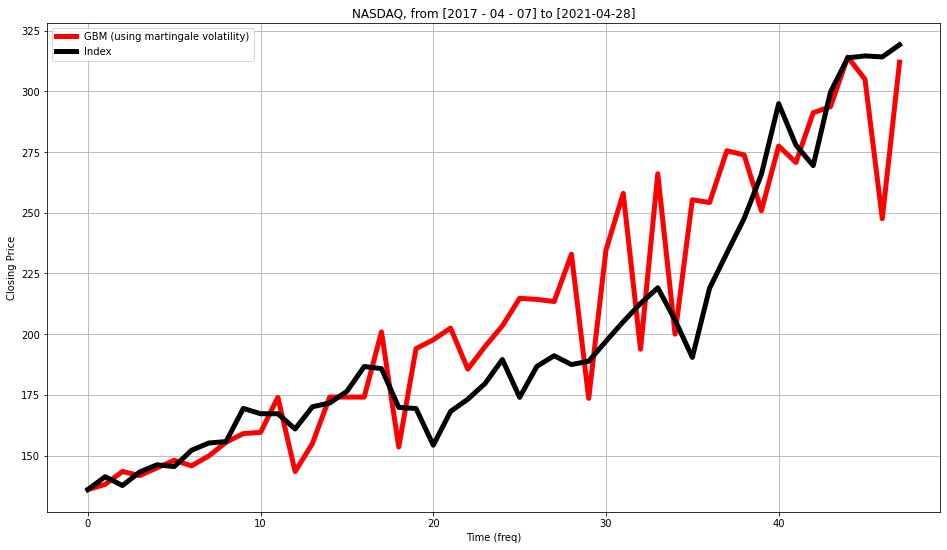

In [ ]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import numpy as np
import math
from scipy.stats import pearsonr


# Set current date to day the code is run
Current_Date = datetime.date.today()


# setting tickers to the tickers we are using 
    # SPY = SP500 , QQQ = NASDAQ, ^VIX = SP500 Volatility Index
tickers = ['SPY', 'QQQ', '^VIX'] 



# choose a starting date, ending date will be the day the code is run
start_date = '2017 - 04 - 07'
end_date = Current_Date


# retreive data using Pandas Datareader using Yahoo Finance (includes Date, Adj Close, Close, High, Low, Open, Volume)
panel_data = data.DataReader(tickers, 'yahoo', start_date,end_date)


# select and reassign only the ticker's open and close values to 'opens' and 'close' respectivly 
close = panel_data['Close']
opens = panel_data['Open']


# select frequency of stocks (change at end of "all_weekdays.. line below)
# Currently on Monthly
    # 'B' = get stock data Daily (business daily)
    # 'W-FRI' = once a week (on fridays)
    # 'SM' = semimonthly
    # 'BM' = monthly (business monthly)
all_weekdays = pd.date_range(start=start_date, end=end_date, freq='BM')


# this reindexes the closes and opens to the date range specified
# this also removes any 'NaN' values (comes from dividend or splits that are included on Yahoo Finance or starting date being a nonbusiness day after choosing business days)
close = close.reindex(all_weekdays)
close = close.fillna(method='ffill')
opens = opens.reindex(all_weekdays)
opens = opens.fillna(method='ffill')


# assign variable index1 as the closing values of ticker = '___' 
    # currently = QQQ (the NASDAQ)
index1 = close.loc[all_weekdays, 'QQQ'] 


# Create the figure (not plotting yet)
fig, ax = plt.subplots(figsize=(16,9),facecolor=('white'))
plt.grid(True)
plt.title("NASDAQ, from [{}] to [{}]".format(start_date,end_date))
plt.xlabel("Time (freq)")
plt.ylabel("Closing Price")
# plt.ylim(0.9*min(spy),1.1*max(spy))
# plt.yscale('log')




####
#####  Solving GBM (St) by assigning constants, randoms, and Brownian motion (Bt)
####

# create a array for number of days for length of Stock data = start_date to end_date, this is our independent variable time
t= np.arange(len(index1)) 

# interval of 1 day/month/week..
dt = 1  


# set inital stock price
S0 = index1[0]


# finding the drift using returns over designated time interval from data [constant] [average and s.d. of stock/index returns for frequency]
# create array named dailyreturns to hold each days move as a decimal 
dailyreturns = []
for i in range(1,index1.size):
    dailyreturns.append(((index1[i] - index1[i-1]) / index1[i-1]))

mu = np.mean(dailyreturns)  
    # = sum(dailyreturns)/len(dailyreturns)

sigma = np.std(dailyreturns) 
    # = math.sqrt(sdt/(len(dailyreturns)-1)), where 



# for Wiener process, need randomly generated numbers from normal distribution [randbt]
# randbt is this random array    [np.random.seed() gives random z with distribution of N(0,1)]
randbt = np.random.normal(0,1, size = (len(dailyreturns)))



#
#
#
# this is the only part that is added
#
# to avoid large differences caused by randomly selecting individally independent numbers (ie. getting a 0.8 and -0.8 back to back is unrealistic for a stock)
# we are going to try to use the nature of GBM, and create a 'random walk' = a martingale GBM, for the volatility (to smooth it out some)
#
# bt is created by a GBM with mu = 0 and sigma = sigma found from index data
bt = []
bt.append(1)
for i in range(0, len(dailyreturns)):     
    # Let s be a random variable = 0 at each iteration
    s = S0*(math.exp((0 - ((sigma*sigma)/2))*t[i] + sigma*(randbt[i]*math.sqrt(dt))))
    bt.append((s/S0)-1) # subtracting 1 and dividing by S0 gives an output that is between [0,1] (will be martingale - will revert sum towards 0)

    
#replace the beginning articifal 1 with something arbitrary
bt[0] = np.mean(bt)
#
#
#
#




# now we have everything for the GBM (St), 
# finding and assigning St motion [where Wt (Wiener Process) = randbt[i]*sqrt(dt)] 
# and sigma is now bt




St = []
St.append(S0)
for i in range(0, len(dailyreturns)):     
    # Let s be a random variable = 0 at each iteration
    s = S0*(math.exp((mu - ((bt[i]**2)/2))*t[i] + bt[i]*(randbt[i]*math.sqrt(dt))))
    St.append(s)
    

#####
    



# Plot GBM and the Index, add legend to plot

ax.plot(t, St, label='GBM (using martingale volatility)', color = 'red', linewidth = 5)
ax.plot(t, index1, label='Index', color = 'black', linewidth = 5)
plt.legend()

# END

pearsonr, _ = pearsonr(St, index1)
print("r correlation (Pearson's r) = {}".format(round(pearsonr,6)))


MAPE_table = pd.DataFrame(index=all_weekdays)
MAPE_table['Actual'] = pd.Series(St, index=all_weekdays)
MAPE_table['Forecast'] = pd.Series(index1)
MAPE_table['MAPE'] = abs((MAPE_table['Actual']-MAPE_table['Forecast'])/MAPE_table['Actual'])
print(" MAPE mean = {}".format(MAPE_table['MAPE'].mean()))